In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tempfile

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("C:\\Users\\user\\Downloads\\market classification project using TCN on interaday Gold data\\hourly features formula one.csv")
print(df)

      Unnamed: 0              date     open     high      low    close  \
0              0    4/22/2025 3:00  3471.10  3475.10  3466.80  3475.10   
1              1    4/22/2025 4:00  3472.57  3494.08  3472.28  3487.27   
2              2    4/22/2025 5:00  3487.55  3487.94  3479.20  3484.67   
3              3    4/22/2025 6:00  3484.95  3495.01  3474.14  3493.26   
4              4    4/22/2025 7:00  3492.59  3499.45  3477.36  3479.42   
...          ...               ...      ...      ...      ...      ...   
2937        2937  10/10/2025 11:00  3995.56  3999.84  3990.61  3993.68   
2938        2938  10/10/2025 12:00  3993.50  3999.70  3983.56  3986.96   
2939        2939  10/10/2025 13:00  3987.35  3993.31  3980.01  3985.40   
2940        2940  10/10/2025 14:00  3985.33  3997.99  3975.26  3978.33   
2941        2941  10/10/2025 15:00  3978.64  3993.93  3970.39  3989.12   

      volume  past_ret_1h  past_ret_2h  past_ret_4h  past_ret_8h  \
0         36    -0.046091    -0.046091    -

In [3]:
features = [
    "date","open","high","low","close","volume",
    "past_ret_1h","past_ret_2h","past_ret_4h","past_ret_8h","past_ret_16h",
    "probability","0.6 percent prediction","1 percent prediction",
    "1.5 percent prediction"
]

In [4]:
df["date"] = pd.to_datetime(df["date"]).map(pd.Timestamp.toordinal)
df = df.fillna(method="ffill").fillna(method="bfill")

C:\Users\user\AppData\Local\Temp\ipykernel_51304\4039671873.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill").fillna(method="bfill")


In [5]:
mapping = {"range": 0, "upward": 1, "downward": -1}
df["forward regime"] = df["forward regime"].map(mapping)

X = df[features]
y = df["forward regime"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [7]:
class_weights = {
    0: 1.511747430249633,
    1: 5.33419689119171,
    -1: 6.620578778135048
}

In [8]:
import os
os.getcwd()

'c:\\Users\\user\\Downloads\\market classification project using TCN on interaday Gold data'

In [9]:
os.chdir("C:\\Users\\user\\Downloads\\market classification project using TCN on interaday Gold data")

In [11]:
from catboost import CatBoostClassifier
from imblearn.over_sampling import RandomOverSampler

model = CatBoostClassifier(
    loss_function="MultiClass",
    depth=8,
    learning_rate=0.03,
    iterations=5000,             # large, but early stopping will stop when needed
    random_seed=42,
    class_weights=class_weights, # important for imbalance
    eval_metric="TotalF1",       # better than accuracy for imbalanced 3-class problems
    od_type="Iter",
    od_wait=100,                 # stop early if no improvement
    task_type="GPU",             # auto falls back to CPU if no GPU
    verbose=200
)

ros = RandomOverSampler(random_state=42)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

model.fit(
    X_resampled, y_resampled,
    eval_set=(X_test, y_test),
    use_best_model=True
)

0:	learn: 0.6351091	test: 0.3815026	best: 0.3815026 (0)	total: 190ms	remaining: 15m 50s
200:	learn: 0.8685275	test: 0.5094868	best: 0.5094868 (200)	total: 1.99s	remaining: 47.6s
400:	learn: 0.9327718	test: 0.6014160	best: 0.6029510 (392)	total: 6.22s	remaining: 1m 11s
600:	learn: 0.9619526	test: 0.6234994	best: 0.6303988 (571)	total: 8.41s	remaining: 1m 1s
800:	learn: 0.9783465	test: 0.6365183	best: 0.6428257 (739)	total: 14s	remaining: 1m 13s
1000:	learn: 0.9870172	test: 0.6413081	best: 0.6493948 (939)	total: 15.9s	remaining: 1m 3s
bestTest = 0.6493948186
bestIteration = 939
Shrink model to first 940 iterations.


In [13]:
y_pred = model.predict(X_test)
y_pred = y_pred.astype(int).flatten()

print("\nCLASSIFICATION REPORT")
print(classification_report(y_test, y_pred))

print("\nCONFUSION MATRIX")
print(confusion_matrix(y_test, y_pred))


CLASSIFICATION REPORT
              precision    recall  f1-score   support

          -1       0.44      0.65      0.52        89
           0       0.83      0.64      0.72       390
           1       0.47      0.65      0.54       110

    accuracy                           0.65       589
   macro avg       0.58      0.65      0.60       589
weighted avg       0.70      0.65      0.66       589


CONFUSION MATRIX
[[ 58  22   9]
 [ 67 251  72]
 [  8  31  71]]


In [14]:
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve
)

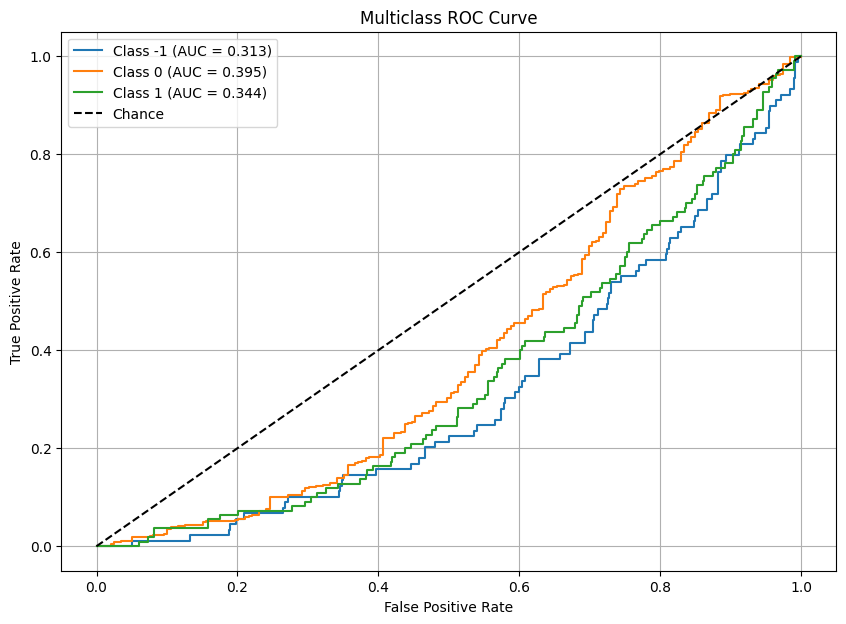

In [16]:
probs = model.predict_proba(X_test)

# Binarize labels
classes = np.unique(y_test)
y_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(10, 7))

for idx, c in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_bin[:, idx], probs[:, idx])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"Class {c} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("Multiclass ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


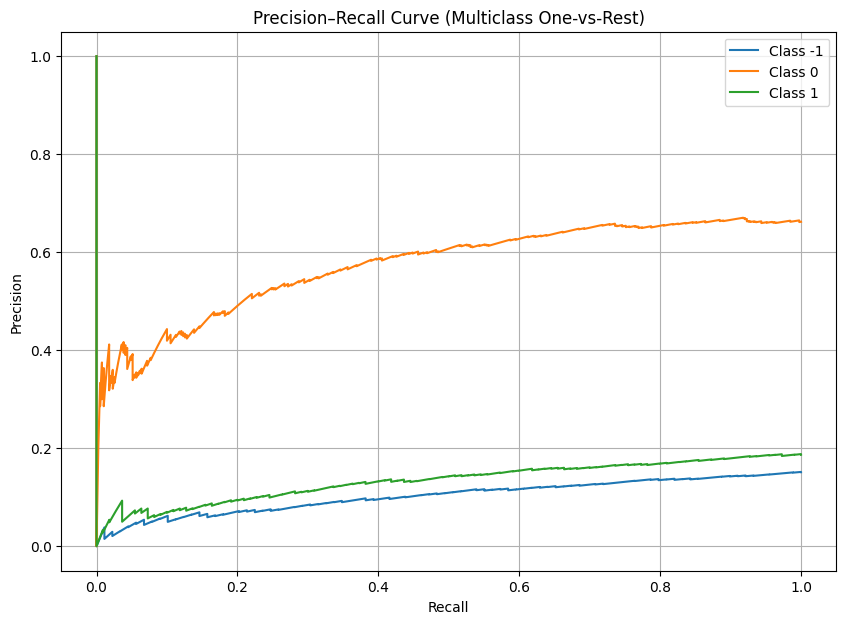

In [17]:
plt.figure(figsize=(10, 7))

for idx, c in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_bin[:, idx], probs[:, idx])
    plt.plot(recall, precision, label=f"Class {c}")

plt.title("Precision–Recall Curve (Multiclass One-vs-Rest)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

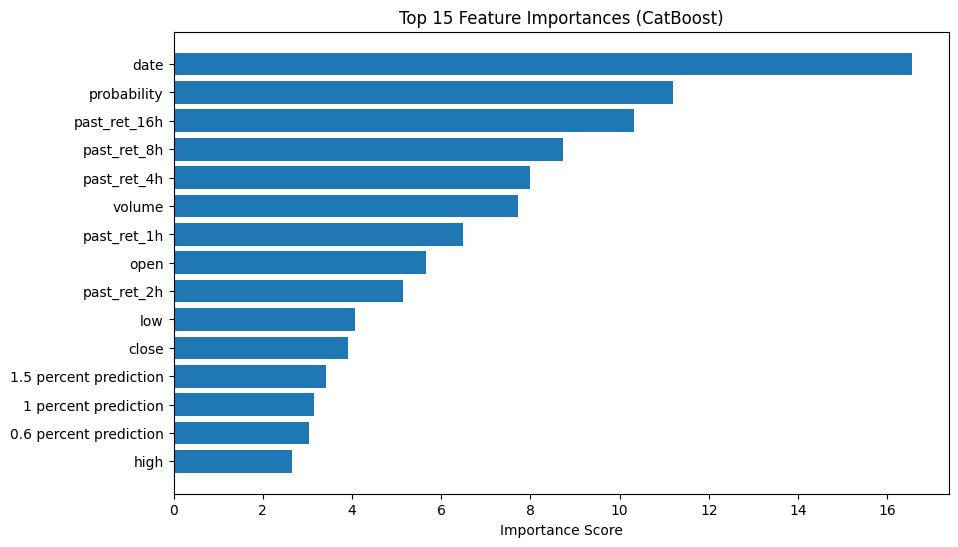

In [18]:
feature_importance = model.get_feature_importance()
feature_names = X_train.columns

sorted_idx = np.argsort(feature_importance)[::-1]
sorted_names = feature_names[sorted_idx]
sorted_scores = feature_importance[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(sorted_names[:15], sorted_scores[:15])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (CatBoost)")
plt.xlabel("Importance Score")
plt.show()
